# SD201 project

- Create dataset from scraping with steam api
- Make apriori algorithm on bought games
- Make knn algorithm on hours played
- Use steam api to make recommendations to a player

# Formulate the question

Knowing the games someone bought and how many hours they played it on Steam, what are the other games they could like and thus potentially buy ?

# Finding the dataset

We'll first test the algorithms on an already existing dataset, and we will then try to create our own dataset with Steam's api.

We choose this dataset : https://www.kaggle.com/datasets/tamber/steam-video-games.  
Indeed, it gives us a huge amount of users with their bought and played games on Steam, which will enable us to predict what kind of games they like (supposing that the more someone plays a game, the more he likes it), 

In [53]:
import pandas as pd

In [7]:
df = pd.read_csv('steam-200k.csv')

In [8]:
df.head()

,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [42]:
df.describe()

,id,hours_played
count,1.999990e+05,199999.000000
mean,1.036556e+08,17.226915
std,7.208084e+07,138.137245
min,5.250000e+03,0.000000
25%,4.738420e+07,0.000000
50%,8.691201e+07,0.000000
75%,1.542309e+08,1.300000
max,3.099031e+08,11754.000000


The dataset cumulates 2 000 000 hours played, which seems enough, and we will check the number of users when the data will be a little bit cleaner.

# Cleaning the data

## Renaming the columns

In [11]:
df.columns = ['id','game','state','hours_played','0']
df.head()

,id,game,state,hours_played,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [17]:
df['id'].nunique()

12393

We have 12393 users in the dataset, which seems to be a good start to create recommendations.

## Removing the column always equals to 0

In [13]:
df = df.drop('0',axis=1)
df.head()

,id,game,state,hours_played
0,151603712,The Elder Scrolls V Skyrim,play,273.0
1,151603712,Fallout 4,purchase,1.0
2,151603712,Fallout 4,play,87.0
3,151603712,Spore,purchase,1.0
4,151603712,Spore,play,14.9


## Look out for NaN values

In [14]:
df.isnull().values.any()

False

There are no NaN values in the dataset

## Separate games bought and games played

In [46]:
bought_games = df.loc[df['state']=='purchase']
played_games = df.loc[df['state']=='play']

For the bought_games, the hours_played has been set to 1 but it is irrelevant, so we can drop the column

In [48]:
bought_games = bought_games.drop('hours_played',axis=1)
bought_games.head()

,id,game,state
1,151603712,Fallout 4,purchase
3,151603712,Spore,purchase
5,151603712,Fallout New Vegas,purchase
7,151603712,Left 4 Dead 2,purchase
9,151603712,HuniePop,purchase


In [47]:
played_games.head()

,id,game,state,hours_played
0,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,play,87.0
4,151603712,Spore,play,14.9
6,151603712,Fallout New Vegas,play,12.1
8,151603712,Left 4 Dead 2,play,8.9


# Visualizing the data

In [54]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Density of hours played by player')

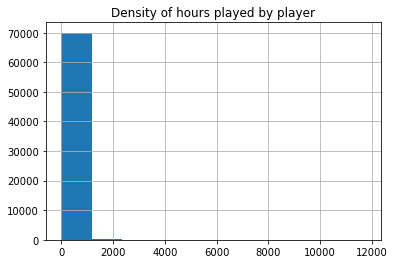

In [57]:
plt.figure()
played_games['hours_played'].hist()
plt.title('Density of hours played by player')

Text(0.5, 1.0, 'Density of games owned by player')

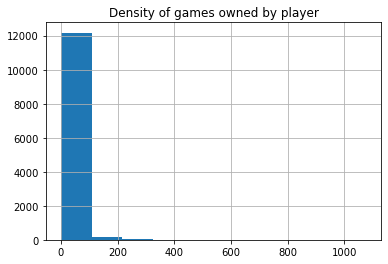

In [56]:
plt.figure()
bought_games.groupby(['id'])['game'].count().hist()
plt.title('Density of games owned by player')

It seems that the distribution is exponential, the majority of players only buy a few games, and play for a few hours. Let's check what happens for the outliers.

Text(0.5, 1.0, 'Density of hours played by outlier players')

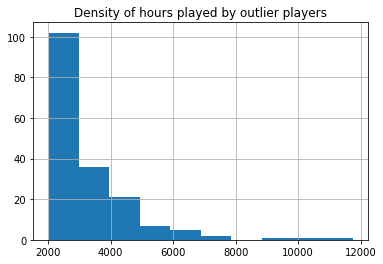

In [60]:
plt.figure()
played_games.loc[played_games['hours_played']>2000,'hours_played'].hist()
plt.title('Density of hours played by outlier players')

Text(0.5, 1.0, 'Density of games owned by outlier players')

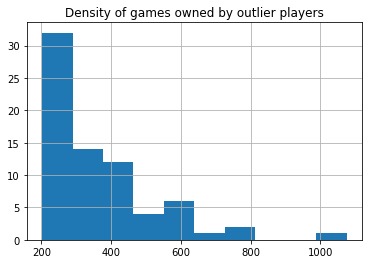

In [61]:
plt.figure()
bought_games.groupby(['id'])['game'].count().loc[bought_games.groupby(['id'])['game'].count()>200].hist()
plt.title('Density of games owned by outlier players')

Even for outliers, the exponential distribution seems to be verified.

# Technical ideas
## 1- Recommendations on games bought -> cluster players depending on the game they have bought
This problem, considering only the games that have been bought, is really similar to the problem of the market basket analysis, and we will thus try to use an apriori algorithm to solve it, which means deducing from the game bought by a person which other games people that buy those usually buy aswell.
## 2- Recommendations base on hours played
K-NN on players

## 1)

In [64]:
from mlxtend.frequent_patterns import apriori, association_rules

To apply the apriori algorithm, we need to rearrange the dataset, with a column for each game and one-hot-encoded lines

In [73]:
#Create lists of games for each player
bought_list = bought_games.groupby(['id'])['game'].apply(list)
bought_list.head()

id
5250      [Cities Skylines, Deus Ex Human Revolution, Po...
76767     [Counter-Strike, Call of Duty World at War, To...
86540     [The Elder Scrolls V Skyrim, Audiosurf, XCOM E...
103360    [Counter-Strike, Counter-Strike Condition Zero...
144736    [Counter-Strike, Day of Defeat, Deathmatch Cla...
Name: game, dtype: object

In [95]:
from sklearn.preprocessing import MultiLabelBinarizer
#One-hot-encode the lists
mlb = MultiLabelBinarizer()

bought_encoded = pd.DataFrame(mlb.fit_transform(bought_list),
                   columns=mlb.classes_)

#The id of the player is no more needed
bought_encoded.head()

,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,samurai_jazz,the static speaks my name,theHunter,theHunter Primal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
frq_items = apriori(bought_encoded, min_support = 0.02, use_colnames = True)
  
# Collecting the inferred rules in a dataframe
rules = association_rules(frq_items, metric ="lift", min_threshold = 0.8)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules.head()

/home/vincent/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Arma 2 Operation Arrowhead Beta (Obsolete)),(Arma 2 Operation Arrowhead),0.020173,0.020173,0.020173,1.0,49.572000,0.019766,inf
1,(Arma 2 Operation Arrowhead),(Arma 2 Operation Arrowhead Beta (Obsolete)),0.020173,0.020173,0.020173,1.0,49.572000,0.019766,inf
6,(Call of Duty Black Ops - Multiplayer),(Call of Duty Black Ops),0.020495,0.020495,0.020495,1.0,48.791339,0.020075,inf
7,(Call of Duty Black Ops),(Call of Duty Black Ops - Multiplayer),0.020495,0.020495,0.020495,1.0,48.791339,0.020075,inf
2110,"(Ricochet, Half-Life Opposing Force)","(Half-Life Blue Shift, Deathmatch Classic)",0.023400,0.023400,0.023400,1.0,42.734483,0.022853,inf


In [139]:
len(rules)

7266

In [142]:
rules.iloc[75]

antecedents           (Ricochet, Half-Life, Team Fortress Classic)
consequents             (Half-Life Blue Shift, Deathmatch Classic)
antecedent support                                          0.0234
consequent support                                          0.0234
support                                                     0.0234
confidence                                                     1.0
lift                                                     42.734483
leverage                                                  0.022853
conviction                                                     inf
Name: 4069, dtype: object

**Note : tests avec les frequent itemsets -> séparer en training/test, pour le test : supprimer un élément du basket, et prédire cet élément avec les règles -> utiliser les métriques classiques de prédiction**